In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install timm

In [ ]:
import os
import numpy as np
import pandas as pd

import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torchvision.models import resnet18
from torchvision.transforms import transforms

from torchvision import models

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import timm
import warnings  
warnings.filterwarnings('ignore')


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
DIR_INPUT = '/content/drive/My Drive/CS444/Final'

SEED = 66
N_FOLDS = 2
N_EPOCHS = 10
BATCH_SIZE = 32
SIZE = 512

In [ ]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
    
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = DIR_INPUT + '/images/' + self.df.loc[idx, 'image_id'] + '.jpg'
        # print(image_src)
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

In [ ]:

transforms_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensorV2()
])

transforms_valid = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensorV2()
])



In [ ]:
submission_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [ ]:
dataset_test = PlantDataset(df=submission_df, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [ ]:
train_df = pd.read_csv(DIR_INPUT + '/train.csv')

# For debugging.
# train_df = train_df.sample(n=100)
# train_df.reset_index(drop=True, inplace=True)

train_labels = train_df.iloc[:, 1:].values

# Need for the StratifiedKFold split
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

train_df.head()
print(train_y)

[2 3 0 ... 0 1 2]


In [ ]:
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_preds = np.zeros((train_df.shape[0], 4))

In [ ]:
class myresnet(nn.Module):
    def __init__(self, num_classes):
        super(myresnet,self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        self.features = nn.Sequential(*list(self.resnet18.children())[:-1])
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.output_fc = nn.Linear(256, 4)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        y_pred = self.output_fc(x)
        return y_pred

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.input_fc = nn.Linear(224*224*3, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        self.dropout = nn.Dropout(0.5)
        self.hidden_fc1 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.output_fc = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(self.bn1(self.input_fc(x)))
        x = F.relu(x)
        x = self.dropout(self.bn2(self.hidden_fc1(x)))
        x = F.relu(x)
        y_pred = self.output_fc(x)
        return y_pred

In [ ]:
class LeafModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = timm.create_model("swin_large_patch4_window7_224", pretrained=True, num_classes=4)
        
    def forward(self, image):
        x = self.model(image)
    
        return x

In [ ]:
class mymobilenet(nn.Module):
    def __init__(self, num_classes):
        super(mymobilenet, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = self.mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(self.mobilenet.last_channel, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.output_fc = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        y_pred = self.output_fc(x)
        return y_pred

In [ ]:
model = LeafModel()

In [ ]:
from IPython.core.display import Image
def train_one_fold(i_fold, model, criterion, optimizer, dataloader_train, dataloader_valid):
    
    train_fold_results = []

    for epoch in range(N_EPOCHS):

        print('  Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
        # print('  ' + ('-' * 20))
        #os.system(f'echo \"  Epoch {epoch}\"')

        #print(f'echo \"  Epoch {epoch}\"')
        model.train()
        tr_loss = 0

        for step, batch in tqdm(enumerate(dataloader_train)):

            images = batch[0]
            labels = batch[1]
            #print(images.shape)
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze(-1))                
            loss.backward()

            tr_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

        # Validate
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None

        for step, batch in enumerate(dataloader_valid):

            images = batch[0]
            labels = batch[1]

            if val_labels is None:
                val_labels = labels.clone().squeeze(-1)
            else:
                val_labels = torch.cat((val_labels, labels.squeeze(-1)), dim=0)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with torch.no_grad():
                outputs = model(images)

                loss = criterion(outputs, labels.squeeze(-1))
                val_loss += loss.item()

                preds = torch.softmax(outputs, dim=1).data.cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)


        train_fold_results.append({
            'fold': i_fold,
            'epoch': epoch,
            'train_loss': tr_loss / len(dataloader_train),
            'valid_loss': val_loss / len(dataloader_valid),
            'valid_score': roc_auc_score(val_labels, val_preds, average='macro'),
        })
        print("score : {}, train loss:{},valid loss:{}".format(roc_auc_score(val_labels, val_preds, average='macro'),tr_loss / len(dataloader_train),val_loss / len(dataloader_valid)))

    return val_preds, train_fold_results

In [ ]:
submissions = None
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_y)):
    print("Fold {}/{}".format(i_fold + 1, N_FOLDS))
    valid = train_df.iloc[valid_idx]
    valid.reset_index(drop=True, inplace=True)

    train = train_df.iloc[train_idx]
    train.reset_index(drop=True, inplace=True)    

    dataset_train = PlantDataset(df=train, transforms=transforms_train)
    dataset_valid = PlantDataset(df=valid, transforms=transforms_valid)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

    device = torch.device("cuda:0")
  
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    plist = [{'params': model.parameters(), 'lr': 1e-4}]
    optimizer = optim.Adam(plist, lr=1e-4)
    
    val_preds, train_fold_results = train_one_fold(i_fold, model, criterion, optimizer, dataloader_train, dataloader_valid)
    oof_preds[valid_idx, :] = val_preds.numpy()
    
    train_results = train_results + train_fold_results

    model.eval()
    test_preds = None

    for step, batch in enumerate(dataloader_test):

        images = batch[0]
        images = images.to(device, dtype=torch.float)

        with torch.no_grad():
            outputs = model(images)

            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
    
    
    # Save predictions per fold
    submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
    submission_df.to_csv('submission_fold_{}.csv'.format(i_fold), index=False)

    # logits avg
    if submissions is None:
        submissions = test_preds / N_FOLDS
    else:
        submissions += test_preds / N_FOLDS

print("2-Folds CV score: {:.4f}".format(roc_auc_score(train_labels, oof_preds, average='macro')))

Fold 1/2
  Epoch 1/10


29it [01:23,  2.86s/it]


score : 0.9427197858837717, train loss:0.48371258570716297,valid loss:0.3238711328855876
  Epoch 2/10


29it [01:13,  2.52s/it]


score : 0.9637747033503372, train loss:0.14728592772936,valid loss:0.19887622709161248
  Epoch 3/10


29it [01:11,  2.48s/it]


score : 0.9632541353713928, train loss:0.08469290636351397,valid loss:0.2907218028759134
  Epoch 4/10


29it [01:12,  2.50s/it]


score : 0.9618158174063512, train loss:0.06886583736872878,valid loss:0.265942808613984
  Epoch 5/10


29it [01:12,  2.50s/it]


score : 0.9644791756739366, train loss:0.0616670693431435,valid loss:0.1887569007511925
  Epoch 6/10


29it [01:12,  2.48s/it]


score : 0.9624443227494407, train loss:0.026536648518983918,valid loss:0.2598376033811605
  Epoch 7/10


29it [01:12,  2.51s/it]


score : 0.9629676828765183, train loss:0.021454897404102415,valid loss:0.3614070771005133
  Epoch 8/10


29it [01:12,  2.50s/it]


score : 0.9831727897489896, train loss:0.0881988737282568,valid loss:0.1771180323517785
  Epoch 9/10


29it [01:11,  2.48s/it]


score : 0.971132779489035, train loss:0.06302695331597251,valid loss:0.21890592401654557
  Epoch 10/10


29it [01:12,  2.50s/it]


score : 0.9758235587959943, train loss:0.02580392709431431,valid loss:0.22262073200143842
Fold 2/2
  Epoch 1/10


29it [01:12,  2.49s/it]


score : 0.999953234605391, train loss:0.17214445172455803,valid loss:0.020237484641758532
  Epoch 2/10


29it [01:13,  2.55s/it]


score : 0.9995786869998545, train loss:0.10886981795895202,valid loss:0.025699933649618822
  Epoch 3/10


29it [01:12,  2.48s/it]


score : 0.9981984265434888, train loss:0.03702871403697043,valid loss:0.04826859750881277
  Epoch 4/10


29it [01:14,  2.56s/it]


score : 0.9983622560624797, train loss:0.028925823571626097,valid loss:0.032265360979463684
  Epoch 5/10


29it [01:11,  2.48s/it]


score : 0.9852726438511263, train loss:0.053871035903033895,valid loss:0.15130629811179022
  Epoch 6/10


29it [01:13,  2.54s/it]


score : 0.9991808988895754, train loss:0.04767768827050218,valid loss:0.03642350789320109
  Epoch 7/10


29it [01:12,  2.49s/it]


score : 0.9972521275332886, train loss:0.012449093556416959,valid loss:0.06652325708298655
  Epoch 8/10


29it [01:12,  2.50s/it]


score : 0.9967522945726477, train loss:0.015372641686804729,valid loss:0.054846086224203866
  Epoch 9/10


29it [01:12,  2.49s/it]


score : 0.9979557115971067, train loss:0.0032237945089381636,valid loss:0.060022868308367144
  Epoch 10/10


29it [01:13,  2.52s/it]


score : 0.996842124433512, train loss:0.038098859295759804,valid loss:0.12076467737467189
2-Folds CV score: 0.9794


In [ ]:
train_results = pd.DataFrame(train_results)
train_results

,fold,epoch,train_loss,valid_loss,valid_score
0,0,0,0.483713,0.323871,0.942720
1,0,1,0.147286,0.198876,0.963775
2,0,2,0.084693,0.290722,0.963254
3,0,3,0.068866,0.265943,0.961816
4,0,4,0.061667,0.188757,0.964479
5,0,5,0.026537,0.259838,0.962444
6,0,6,0.021455,0.361407,0.962968
7,0,7,0.088199,0.177118,0.983173
8,0,8,0.063027,0.218906,0.971133
9,0,9,0.025804,0.222621,0.975824


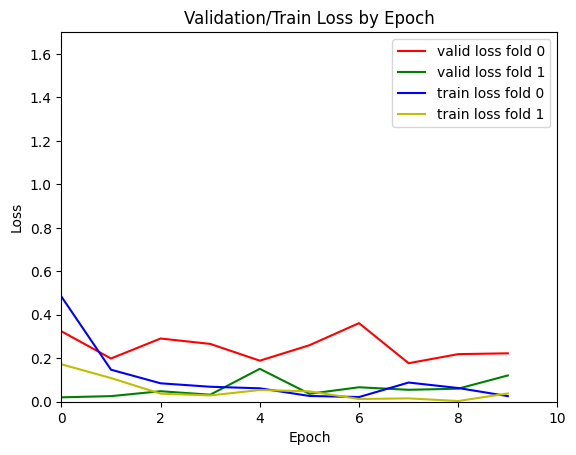

In [ ]:
import matplotlib.pyplot as plt

data1 = train_results[train_results['fold'] == 0]
data1 = data1.iloc[0:10]
data1 = data1['valid_loss']
epochs = range(10)

plt.plot(epochs, data1, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation/Train Loss by Epoch')
plt.ylim(0, 1.7)
plt.xlim(0, 10)

data2 = train_results[train_results['fold'] == 1]
data2 = data2.iloc[0:10]
data2 = data2['valid_loss']
plt.plot(epochs, data2, 'g')

data3 = train_results[train_results['fold'] == 0]
data3 = data3.iloc[0:10]
data3 = data3['train_loss']
plt.plot(epochs, data3, 'b')

data4 = train_results[train_results['fold'] == 1]
data4 = data4.iloc[0:10]
data4 = data4['train_loss']
plt.plot(epochs, data4, 'y')
plt.legend(['valid loss fold 0','valid loss fold 1','train loss fold 0','train loss fold 1'])
plt.show()


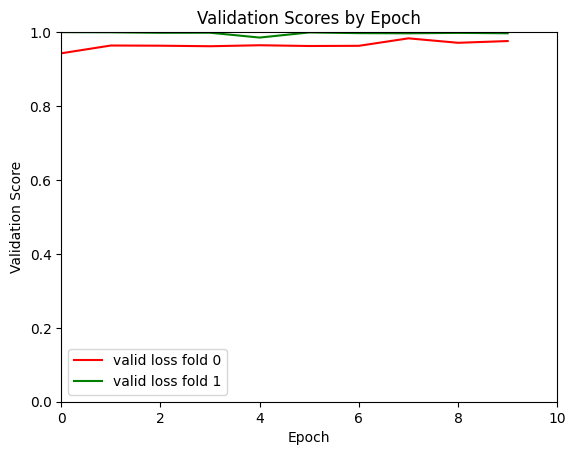

In [ ]:
data1 = train_results[train_results['fold'] == 0]
data1 = data1.iloc[0:20]
data1 = data1['valid_score']
epochs = range(10)

plt.plot(epochs, data1, 'r')
plt.xlabel('Epoch')
plt.ylabel('Validation Score')
plt.title('Validation Scores by Epoch')
plt.ylim(0, 1.0)
plt.xlim(0, 10)

data2 = train_results[train_results['fold'] == 1]
data2 = data2.iloc[0:10]
data2 = data2['valid_score']
plt.plot(epochs, data2, 'g')

plt.legend(['valid loss fold 0','valid loss fold 1'])
plt.show()